In [13]:
'''
%pip install qiskit 
%pip install docplex
%pip install qiskit_optimization
%pip install networkx
%pip install geopandas
%pip install folium
%pip install pandas
%pip install numpy

%pip install qiskit-ibm-experiment
%pip install qiskit-ibm-runtime
%pip install qiskit-ibm-provider
%pip install geodatasets
%pip install qiskit-optimization[cplex]

%pip install dimod
%pip install matplotlib
%pip install itertools
%pip install dwave.samplers
'''

'\n%pip install qiskit \n%pip install docplex\n%pip install qiskit_optimization\n%pip install networkx\n%pip install geopandas\n%pip install folium\n%pip install pandas\n%pip install numpy\n\n%pip install qiskit-ibm-experiment\n%pip install qiskit-ibm-runtime\n%pip install qiskit-ibm-provider\n%pip install geodatasets\n%pip install qiskit-optimization[cplex]\n\n%pip install dimod\n%pip install matplotlib\n%pip install itertools\n%pip install dwave.samplers\n'

In [14]:
import networkx as nx
import geopandas as gpd
import folium
import dimod

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import time
import random

from IPython.display import display
from docplex.mp.model import Model

from itertools import product
from dwave.samplers import *

from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer

from geodatasets import get_path

# https://github.com/alejomonbar/Quantum-Supply-Chain-Manager/

In [15]:
path_to_file = get_path('nybb')
df = gpd.read_file(path_to_file)

In [16]:
m = folium.Map(location=[40.70, -73.94], zoom_start=10, max_zoom=12, tiles='CartoDB positron')
    
# Project to NAD83 projected crs
df = df.to_crs(epsg=2263)

# Access the centroid attribute of each polygon
df['centroid'] = df.centroid

# Project to WGS84 geographic crs

# geometry (active) column
df = df.to_crs(epsg=4326)

# Centroid column
df['centroid'] = df['centroid'].to_crs(epsg=4326)

np.random.seed(7)
locations = []
ids = 0
for _, r in df.iterrows():
    lat, lon = r['centroid'].y, r['centroid'].x
    for i in range(2):
        lat_rand, lon_rand = lat + 0.2 * np.random.rand(), lon +0.1 * np.random.rand()
        locations.append((lon_rand, lat_rand))
        folium.Marker(location=[lat_rand, lon_rand], popup=f'Id: {ids}').add_to(m)
        ids += 1
center = np.array(locations).mean(axis=0)
locations = [(center[0], center[1])] + locations
folium.CircleMarker(location=[center[1], center[0]], radius=10, popup="<stong>Warehouse</stong>",
                    color="red",fill=True, fillOpacity=1, fillColor="tab:red").add_to(m)
m

In [17]:
# Normalizing the results to produce a graph in Graphx
companies = np.array(locations)
companies -= companies[0]
companies /= (np.max(np.abs(companies), axis=0))
r = list(np.sqrt(np.sum(companies ** 2, axis=1)))

The number of edges of this problem is: 34


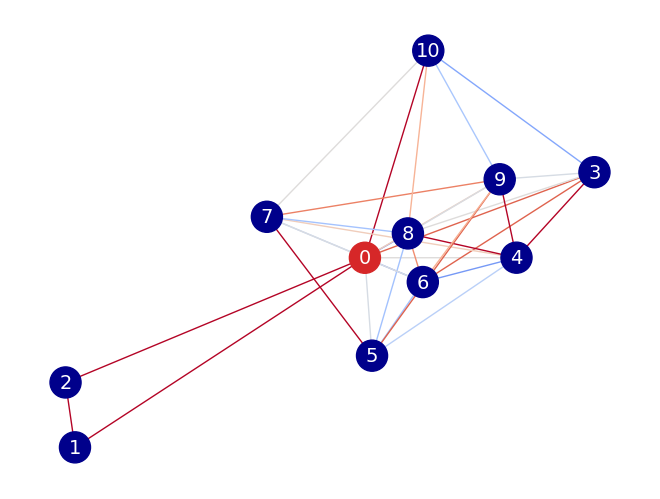

In [18]:
threshold = 1 # Limit for to not consider the route from company i to j if the distance is larger than a threshold
n_companies = len(companies)
G = nx.Graph(name="VRP")
G.add_nodes_from(range(n_companies))
# G.add_weighted_edges_from([0, i, w] for i, w in zip(range(1, n_companies), r[1:]))
np.random.seed(2)
count = 0
for i in range(n_companies):
    for j in range(n_companies):
        if i != j:
            rij = np.sqrt(np.sum((companies[i] - companies[j])**2))
            if (rij < threshold) or (0 in [i, j]):
                count +=1
                G.add_weighted_edges_from([[i, j, rij]])
                r.append(rij)
colors = [plt.colormaps.get_cmap("coolwarm")(x) for x in r[1:]]
nx.draw(G, pos=companies, with_labels=True, node_size=500,
        edge_color=colors, width=1, font_color="white",font_size=14,
        node_color = ["tab:red"] + (n_companies-1)*["darkblue"])
print(f"The number of edges of this problem is: {len(G.edges)}")

In [19]:
mdl = Model(name="VRP")
n_trucks = 3 # number of K trucks
x = {}
for i, j in G.edges():
    x[(i, j)] = mdl.binary_var(name=f"x_{i}_{j}") # Adding route from company i to company j as a binary variable
    x[(j, i)] = mdl.binary_var(name=f"x_{j}_{i}") # Adding route from company j to company i as a binary variable

print(f"The number of qubits needed to solve the problem is: {mdl.number_of_binary_variables}")
cost_func = mdl.sum(w["weight"] * x[(i, j)] for i, j, w in G.edges(data=True)) + mdl.sum(w["weight"] * x[(j, i)] for i, j, w in G.edges(data=True))
mdl.minimize(cost_func)

# Constraint 1a(yellow Fig. above): Only one truck goes out from company i 
for i in range(1, n_companies):
    mdl.add_constraint(mdl.sum(x[i, j] for j in range(n_companies) if (i, j) in x.keys()) == 1)
# Constraint 1b (yellow Fig. above): Only one truck comes into company j 
for j in range(1, n_companies):
    mdl.add_constraint(mdl.sum(x[i, j] for i in range(n_companies) if (i, j) in x.keys()) == 1)
# Constraint 2: (orange Fig. above) For the warehouse
mdl.add_constraint(mdl.sum(x[i, 0] for i in range(1, n_companies)) == n_trucks)
mdl.add_constraint(mdl.sum(x[0, j] for j in range(1, n_companies)) == n_trucks)

# Constraint 3: (blue Fig. above) To eliminate sub-routes
companies_list = list(range(1, n_companies))
subroute_set = []
for i in range(2, len(companies_list) + 1):
    for comb in itertools.combinations(companies_list, i):
        subroute_set.append(list(comb)) #subset points

for subroute in subroute_set:
    constraint_3 = []
    for i, j in itertools.permutations(subroute, 2): #iterating over all the subset points
        if (i, j) in x.keys():
            constraint_3.append(x[(i,j)])
        elif i == j:
            pass
        else:
            constraint_3 = []
            break
    if len(constraint_3) != 0:
        mdl.add_constraint(mdl.sum(constraint_3) <= len(subroute) - 1)

quadratic_program = from_docplex_mp(mdl)
print(quadratic_program.export_as_lp_string())

The number of qubits needed to solve the problem is: 68
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: VRP

Minimize
 obj: 1.332623442714 x_0_1 + 1.332623442714 x_1_0 + 1.167267340961 x_0_2
      + 1.167267340961 x_2_0 + 0.870924584994 x_0_3 + 0.870924584994 x_3_0
      + 0.506337604554 x_0_4 + 0.506337604554 x_4_0 + 0.473427767721 x_0_5
      + 0.473427767721 x_5_0 + 0.226286197585 x_0_6 + 0.226286197585 x_6_0
      + 0.382564916313 x_0_7 + 0.382564916313 x_7_0 + 0.185594213224 x_0_8
      + 0.185594213224 x_8_0 + 0.588478457259 x_0_9 + 0.588478457259 x_9_0
      + 1.022163668163 x_0_10 + 1.022163668163 x_10_0 + 0.314878112966 x_1_2
      + 0.314878112966 x_2_1 + 0.487918004849 x_3_4 + 0.487918004849 x_4_3
      + 0.781044787250 x_3_6 + 0.781044787250 x_6_3 + 0.689644793506 x_3_8
      + 0.689644793506 x_8_3 + 0.318359687012 x_3_9 + 0.318359687012 x_9_3
      + 0.807887929520 x_3_10 + 0.807887929520 x_10_3 + 0.675868194806 x_4_5
      + 0.675868194806 x

"Quantum" Solution

In [20]:
sol = CplexOptimizer().solve(quadratic_program)

In [21]:
qubo = QuadraticProgramToQubo(penalty=15).convert(quadratic_program)
num_vars = qubo.get_num_binary_vars()
new_qubo = qubo.substitute_variables(sol.variables_dict)

In [22]:
sol_slack = CplexOptimizer().solve(new_qubo)
qubo_no_slack = qubo.substitute_variables(sol_slack.variables_dict)
sol_no_slack = CplexOptimizer().solve(qubo_no_slack)

In [23]:
print(qubo.variables)

[<Variable: x_0_1 (binary)>, <Variable: x_1_0 (binary)>, <Variable: x_0_2 (binary)>, <Variable: x_2_0 (binary)>, <Variable: x_0_3 (binary)>, <Variable: x_3_0 (binary)>, <Variable: x_0_4 (binary)>, <Variable: x_4_0 (binary)>, <Variable: x_0_5 (binary)>, <Variable: x_5_0 (binary)>, <Variable: x_0_6 (binary)>, <Variable: x_6_0 (binary)>, <Variable: x_0_7 (binary)>, <Variable: x_7_0 (binary)>, <Variable: x_0_8 (binary)>, <Variable: x_8_0 (binary)>, <Variable: x_0_9 (binary)>, <Variable: x_9_0 (binary)>, <Variable: x_0_10 (binary)>, <Variable: x_10_0 (binary)>, <Variable: x_1_2 (binary)>, <Variable: x_2_1 (binary)>, <Variable: x_3_4 (binary)>, <Variable: x_4_3 (binary)>, <Variable: x_3_6 (binary)>, <Variable: x_6_3 (binary)>, <Variable: x_3_8 (binary)>, <Variable: x_8_3 (binary)>, <Variable: x_3_9 (binary)>, <Variable: x_9_3 (binary)>, <Variable: x_3_10 (binary)>, <Variable: x_10_3 (binary)>, <Variable: x_4_5 (binary)>, <Variable: x_5_4 (binary)>, <Variable: x_4_6 (binary)>, <Variable: x_6_

In [24]:
print(list(sol_slack.variables_dict))

['c46@int_slack@0', 'c46@int_slack@1', 'c47@int_slack@0', 'c47@int_slack@1', 'c48@int_slack@0', 'c48@int_slack@1', 'c49@int_slack@0', 'c49@int_slack@1', 'c50@int_slack@0', 'c50@int_slack@1', 'c51@int_slack@0', 'c51@int_slack@1', 'c52@int_slack@0', 'c52@int_slack@1', 'c53@int_slack@0', 'c53@int_slack@1', 'c54@int_slack@0', 'c54@int_slack@1', 'c55@int_slack@0', 'c55@int_slack@1', 'c56@int_slack@0', 'c56@int_slack@1', 'c57@int_slack@0', 'c57@int_slack@1', 'c58@int_slack@0', 'c58@int_slack@1', 'c59@int_slack@0', 'c59@int_slack@1', 'c60@int_slack@0', 'c60@int_slack@1', 'c61@int_slack@0', 'c61@int_slack@1', 'c62@int_slack@0', 'c62@int_slack@1', 'c63@int_slack@0', 'c63@int_slack@1', 'c64@int_slack@0', 'c64@int_slack@1', 'c65@int_slack@0', 'c65@int_slack@1', 'c66@int_slack@0', 'c66@int_slack@1', 'c67@int_slack@0', 'c67@int_slack@1', 'c68@int_slack@0', 'c68@int_slack@1', 'c69@int_slack@0', 'c69@int_slack@1', 'c70@int_slack@0', 'c70@int_slack@1', 'c71@int_slack@0', 'c71@int_slack@1', 'c72@int_sl

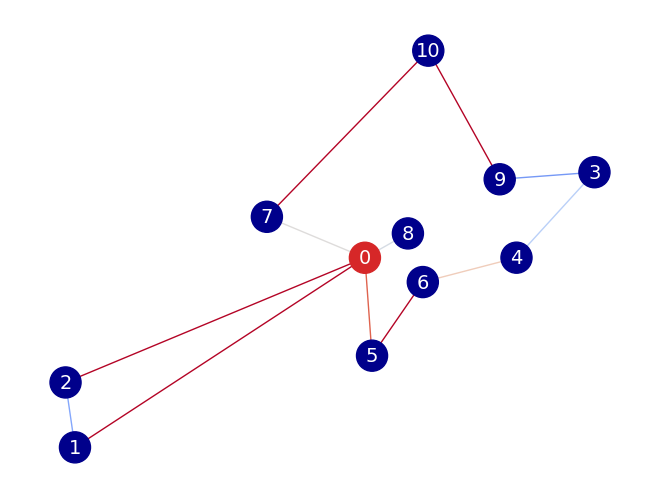

In [25]:
solution_slack = sol_no_slack.raw_results.as_name_dict()
G_sol_slack = nx.Graph()
G_sol_slack.add_nodes_from(range(n_companies))
for i in solution_slack:
    nodes = i[2:].split("_")
    G_sol_slack.add_edge(int(nodes[0]), int(nodes[1]))
nx.draw(G_sol_slack, pos=companies, with_labels=True, node_size=500,
        edge_color=colors, width=1, font_color="white",font_size=14,
        node_color = ["tab:red"] + (n_companies-1)*["darkblue"])

In [26]:
# Extract QUBO model
qubo_matrix = qubo.objective.quadratic.to_array()
linear_coefficients = qubo.objective.linear.to_array()
quadratic_coefficients = {(i, j): qubo_matrix[i, j] for i in range(len(qubo_matrix)) for j in range(len(qubo_matrix)) if qubo_matrix[i, j] != 0}

# Combine linear and quadratic parts
Q = quadratic_coefficients.copy()
Q.update({(i, i): linear_coefficients[i] for i in range(len(linear_coefficients))})
names = [var.name for var in qubo.variables]

li = list(quadratic_program.variables_index.keys())

In [27]:
print(qubo_matrix)

[[ 30.   0.  30. ...   0.   0.   0.]
 [  0.  30.   0. ...   0.   0.   0.]
 [  0.   0.  30. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  15.  60.  60.]
 [  0.   0.   0. ...   0.  60. 120.]
 [  0.   0.   0. ...   0.   0.  60.]]


In [28]:
print(names)

['x_0_1', 'x_1_0', 'x_0_2', 'x_2_0', 'x_0_3', 'x_3_0', 'x_0_4', 'x_4_0', 'x_0_5', 'x_5_0', 'x_0_6', 'x_6_0', 'x_0_7', 'x_7_0', 'x_0_8', 'x_8_0', 'x_0_9', 'x_9_0', 'x_0_10', 'x_10_0', 'x_1_2', 'x_2_1', 'x_3_4', 'x_4_3', 'x_3_6', 'x_6_3', 'x_3_8', 'x_8_3', 'x_3_9', 'x_9_3', 'x_3_10', 'x_10_3', 'x_4_5', 'x_5_4', 'x_4_6', 'x_6_4', 'x_4_7', 'x_7_4', 'x_4_8', 'x_8_4', 'x_4_9', 'x_9_4', 'x_5_6', 'x_6_5', 'x_5_7', 'x_7_5', 'x_5_8', 'x_8_5', 'x_5_9', 'x_9_5', 'x_6_7', 'x_7_6', 'x_6_8', 'x_8_6', 'x_6_9', 'x_9_6', 'x_7_8', 'x_8_7', 'x_7_9', 'x_9_7', 'x_7_10', 'x_10_7', 'x_8_9', 'x_9_8', 'x_8_10', 'x_10_8', 'x_9_10', 'x_10_9', 'c46@int_slack@0', 'c46@int_slack@1', 'c47@int_slack@0', 'c47@int_slack@1', 'c48@int_slack@0', 'c48@int_slack@1', 'c49@int_slack@0', 'c49@int_slack@1', 'c50@int_slack@0', 'c50@int_slack@1', 'c51@int_slack@0', 'c51@int_slack@1', 'c52@int_slack@0', 'c52@int_slack@1', 'c53@int_slack@0', 'c53@int_slack@1', 'c54@int_slack@0', 'c54@int_slack@1', 'c55@int_slack@0', 'c55@int_slack@1

In [29]:
print(qubo)

minimize 15*c100@int_slack@0^2 + 60*c100@int_slack@0*c100@int_slack@1 + 30*c100@int_slack@0*c100@int_slack@2 + 60*c100@int_slack@1^2 + 60*c100@int_slack@1*c100@int_slack@2 + 15*c100@int_slack@2^2 + 15*c101@int_slack@0^2 + 60*c101@int_slack@0*c101@int_slack@1 + 30*c101@int_slack@0*c101@int_slack@2 + 60*c101@int_slack@1^2 + 60*c101@int_slack@1*c101@int_slack@2 + 15*c101@int_slack@2^2 + 15*c102@int_slack@0^2 + 60*c102@int_slack@0*c102@int_slack@1 + 30*c102@int_slack@0*c102@int_slack@2 + 60*c102@int_slack@1^2 + 60*c102@int_slack@1*c102@int_slack@2 + 15*c102@int_slack@2^2 + 15*c103@int_slack@0^2 + 60*c103@int_slack@0*c103@int_slack@1 + 30*c103@int_slack@0*c103@int_slack@2 + 60*c103@int_slack@1^2 + 60*c103@int_slack@1*c103@int_slack@2 + 15*c103@int_slack@2^2 + 15*c104@int_slack@0^2 + 60*c104@int_slack@0*c104@int_slack@1 + 30*c104@int_slack@0*c104@int_slack@2 + 60*c104@int_slack@1^2 + 60*c104@int_slack@1*c104@int_slack@2 + 15*c104@int_slack@2^2 + 15*c105@int_slack@0^2 + 60*c105@int_slack@0*c1

In [30]:
print(quadratic_program.variables_index)
print(li)

{'x_0_1': 0, 'x_1_0': 1, 'x_0_2': 2, 'x_2_0': 3, 'x_0_3': 4, 'x_3_0': 5, 'x_0_4': 6, 'x_4_0': 7, 'x_0_5': 8, 'x_5_0': 9, 'x_0_6': 10, 'x_6_0': 11, 'x_0_7': 12, 'x_7_0': 13, 'x_0_8': 14, 'x_8_0': 15, 'x_0_9': 16, 'x_9_0': 17, 'x_0_10': 18, 'x_10_0': 19, 'x_1_2': 20, 'x_2_1': 21, 'x_3_4': 22, 'x_4_3': 23, 'x_3_6': 24, 'x_6_3': 25, 'x_3_8': 26, 'x_8_3': 27, 'x_3_9': 28, 'x_9_3': 29, 'x_3_10': 30, 'x_10_3': 31, 'x_4_5': 32, 'x_5_4': 33, 'x_4_6': 34, 'x_6_4': 35, 'x_4_7': 36, 'x_7_4': 37, 'x_4_8': 38, 'x_8_4': 39, 'x_4_9': 40, 'x_9_4': 41, 'x_5_6': 42, 'x_6_5': 43, 'x_5_7': 44, 'x_7_5': 45, 'x_5_8': 46, 'x_8_5': 47, 'x_5_9': 48, 'x_9_5': 49, 'x_6_7': 50, 'x_7_6': 51, 'x_6_8': 52, 'x_8_6': 53, 'x_6_9': 54, 'x_9_6': 55, 'x_7_8': 56, 'x_8_7': 57, 'x_7_9': 58, 'x_9_7': 59, 'x_7_10': 60, 'x_10_7': 61, 'x_8_9': 62, 'x_9_8': 63, 'x_8_10': 64, 'x_10_8': 65, 'x_9_10': 66, 'x_10_9': 67}
['x_0_1', 'x_1_0', 'x_0_2', 'x_2_0', 'x_0_3', 'x_3_0', 'x_0_4', 'x_4_0', 'x_0_5', 'x_5_0', 'x_0_6', 'x_6_0', 'x_0_7

: 

In [226]:
print(qubo_matrix)

[[ 30.   0.  30. ...   0.   0.   0.]
 [  0.  30.   0. ...   0.   0.   0.]
 [  0.   0.  30. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  15.  60.  60.]
 [  0.   0.   0. ...   0.  60. 120.]
 [  0.   0.   0. ...   0.   0.  60.]]


In [227]:
print(qubo.variables)

print(li)
non_slack_variables_dict = {var: li.index(var) for var in list(sol_slack.variables_dict)}
print(non_slack_variables_dict)

[<Variable: x_0_1 (binary)>, <Variable: x_1_0 (binary)>, <Variable: x_0_2 (binary)>, <Variable: x_2_0 (binary)>, <Variable: x_0_3 (binary)>, <Variable: x_3_0 (binary)>, <Variable: x_0_4 (binary)>, <Variable: x_4_0 (binary)>, <Variable: x_0_5 (binary)>, <Variable: x_5_0 (binary)>, <Variable: x_0_6 (binary)>, <Variable: x_6_0 (binary)>, <Variable: x_0_7 (binary)>, <Variable: x_7_0 (binary)>, <Variable: x_0_8 (binary)>, <Variable: x_8_0 (binary)>, <Variable: x_0_9 (binary)>, <Variable: x_9_0 (binary)>, <Variable: x_0_10 (binary)>, <Variable: x_10_0 (binary)>, <Variable: x_1_2 (binary)>, <Variable: x_2_1 (binary)>, <Variable: x_3_4 (binary)>, <Variable: x_4_3 (binary)>, <Variable: x_3_6 (binary)>, <Variable: x_6_3 (binary)>, <Variable: x_3_8 (binary)>, <Variable: x_8_3 (binary)>, <Variable: x_3_9 (binary)>, <Variable: x_9_3 (binary)>, <Variable: x_3_10 (binary)>, <Variable: x_10_3 (binary)>, <Variable: x_4_5 (binary)>, <Variable: x_5_4 (binary)>, <Variable: x_4_6 (binary)>, <Variable: x_6_

In [228]:
print(li)
print(len(li))


print(len(sol.variables_dict))
print(len(quadratic_coefficients))


['x_0_1', 'x_1_0', 'x_0_2', 'x_2_0', 'x_0_3', 'x_3_0', 'x_0_4', 'x_4_0', 'x_0_5', 'x_5_0', 'x_0_6', 'x_6_0', 'x_0_7', 'x_7_0', 'x_0_8', 'x_8_0', 'x_0_9', 'x_9_0', 'x_0_10', 'x_10_0', 'x_1_2', 'x_2_1', 'x_3_4', 'x_4_3', 'x_3_6', 'x_6_3', 'x_3_8', 'x_8_3', 'x_3_9', 'x_9_3', 'x_3_10', 'x_10_3', 'x_4_5', 'x_5_4', 'x_4_6', 'x_6_4', 'x_4_7', 'x_7_4', 'x_4_8', 'x_8_4', 'x_4_9', 'x_9_4', 'x_5_6', 'x_6_5', 'x_5_7', 'x_7_5', 'x_5_8', 'x_8_5', 'x_5_9', 'x_9_5', 'x_6_7', 'x_7_6', 'x_6_8', 'x_8_6', 'x_6_9', 'x_9_6', 'x_7_8', 'x_8_7', 'x_7_9', 'x_9_7', 'x_7_10', 'x_10_7', 'x_8_9', 'x_9_8', 'x_8_10', 'x_10_8', 'x_9_10', 'x_10_9', 'c46@int_slack@0', 'c46@int_slack@1', 'c47@int_slack@0', 'c47@int_slack@1', 'c48@int_slack@0', 'c48@int_slack@1', 'c49@int_slack@0', 'c49@int_slack@1', 'c50@int_slack@0', 'c50@int_slack@1', 'c51@int_slack@0', 'c51@int_slack@1', 'c52@int_slack@0', 'c52@int_slack@1', 'c53@int_slack@0', 'c53@int_slack@1', 'c54@int_slack@0', 'c54@int_slack@1', 'c55@int_slack@0', 'c55@int_slack@1

In [229]:
solvers = {'Simulated Annealing': SimulatedAnnealingSampler(),
            'Steepest Descent': SteepestDescentSolver()}

sim_count = 5



In [245]:
def sample_solver(value):
    # Sample given solver, with sim_count repeats.
    sample = value.sample_qubo(Q, num_reads=sim_count)
    timing_ms = {key.split('_')[0]: value / 1_000_000 for key, value in sample.info["timing"].items()}
        # Create a string representation of the data.
    time_data = ', '.join(f'{key}: {value:.2f} ms' for key, value in timing_ms.items())
    sample_2 = sample.aggregate().lowest()
    sample_arr = sample.record[0][0]
    sample_arr2 = sample_arr[:67]
    unique, counts = np.unique(sample_arr2, return_counts=True)

    print(sample.variables)
    #print(time_data)
    print(sample_arr)
    #print(counts)
    #print(solution_slack)
    #print(sample_2.record[0][0])
    #print(type(sample_2))

sample_solver(SimulatedAnnealingSampler())
#sample_solver(SteepestDescentSolver())



Variables(range(0, 196))
[1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1
 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1
 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0
 1 1 1 1 0 1 1 0 1 0 1]


In [243]:
print(sol.raw_results)

solution for: VRP
objective: 7.20821
status: OPTIMAL_SOLUTION(2)
x_0_1=1
x_2_0=1
x_0_5=1
x_7_0=1
x_0_8=1
x_8_0=1
x_1_2=1
x_4_3=1
x_3_9=1
x_6_4=1
x_5_6=1
x_10_7=1
x_9_10=1



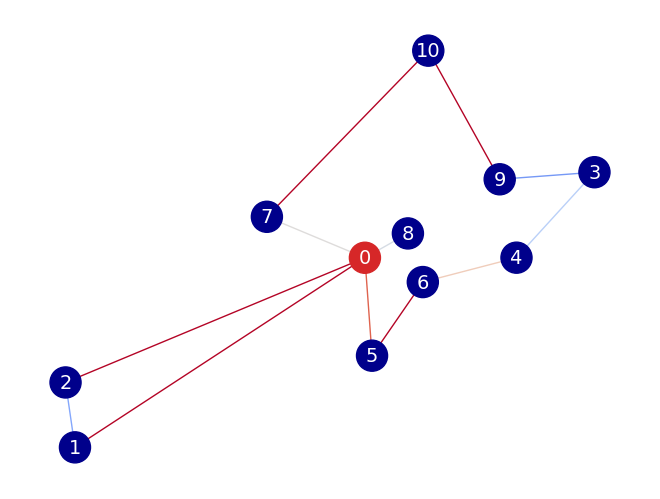

In [19]:
solution_cplex = sol.raw_results.as_name_dict()
G_sol = nx.Graph()
G_sol.add_nodes_from(range(n_companies))
for i in solution_cplex:
    nodes = i[2:].split("_")
    G_sol.add_edge(int(nodes[0]), int(nodes[1]))
nx.draw(G_sol, pos=companies, with_labels=True, node_size=500,
        edge_color=colors, width=1, font_color="white",font_size=14,
        node_color = ["tab:red"] + (n_companies-1)*["darkblue"])